In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from fuzzywuzzy import fuzz 

sns.set_palette("husl")

%matplotlib inline

In [2]:
tweets = pd.read_csv('./data/train.csv', encoding='utf-8')
tweets.loc[:,'keyword'] = tweets.loc[:,'keyword'].str.replace("%20", " ")
tweets.sample(10)

,id,keyword,location,text,target
3693,5255,fatality,Earth,I liked a @YouTube video from @deathmule http:...,0
537,782,avalanche,Buy Give Me My Money,Great one time deal on all Avalanche music and...,0
4156,5905,harm,WORLD WIDE,ÛÏFor I know the plans I have for youÛ decl...,0
1475,2125,catastrophe,"Brooklyn, NY",UPDATE: 7 of the 9 Mac Pros my company bought ...,1
6562,9388,survived,"Austin, TX",Survived Spanish!! @ Sweet Ritual https://t.co...,0
3289,4715,evacuate,New England,'So again make sure to evacuate past the fire ...,0
5141,7331,nuclear reactor,Aztec NM,US Energy Department Offers $40Mln for New Nuc...,0
7481,10702,wreck,NaN,the sunset boys wreck my bed original 1979 u...,1
1038,1504,body bags,#937??#734,@baskgod body bags,0
3542,5064,famine,"Kyiv, Ukraine",#Russia 'food crematoria' provoke outrage in c...,1


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Análisis de Keyword vs Target

## ¿Cuántas keywords únicas?

In [4]:
len(tweets.keyword.unique())

222




## Categorizar "keyword"

In [5]:
#Recibe una lista de keywords y regresa un diccionario cuyas claves son los elementos de la lista pasada y los valores
#son las keywords agrupadas que las representa
def get_keyword_dic(key_list):
    key_dic = {}
    unique_list = []
    for x in key_list:
        similarity = 0
        value = ""
        for y in unique_list:
            ratio = fuzz.ratio(x,y)
            if ratio > similarity:
                similarity = ratio
                value = y
        if similarity > 75:
            key_dic[x] = value
        else:
            key_dic[x] = x
            unique_list.append(x)
    return key_dic
categorical_keyword = get_keyword_dic(tweets.loc[:,'keyword'].dropna().tolist())

In [6]:
categorical_keyword

{'ablaze': 'ablaze',
 'accident': 'accident',
 'aftershock': 'aftershock',
 'airplane accident': 'airplane accident',
 'ambulance': 'ambulance',
 'annihilated': 'annihilated',
 'annihilation': 'annihilated',
 'apocalypse': 'apocalypse',
 'armageddon': 'armageddon',
 'army': 'army',
 'arson': 'arson',
 'arsonist': 'arson',
 'attack': 'attack',
 'attacked': 'attack',
 'avalanche': 'avalanche',
 'battle': 'battle',
 'bioterror': 'bioterror',
 'bioterrorism': 'bioterror',
 'blaze': 'ablaze',
 'blazing': 'blazing',
 'bleeding': 'bleeding',
 'blew up': 'blew up',
 'blight': 'blight',
 'blizzard': 'blizzard',
 'blood': 'blood',
 'bloody': 'blood',
 'blown up': 'blew up',
 'body bag': 'body bag',
 'body bagging': 'body bag',
 'body bags': 'body bag',
 'bomb': 'bomb',
 'bombed': 'bomb',
 'bombing': 'bombing',
 'bridge collapse': 'bridge collapse',
 'buildings burning': 'buildings burning',
 'buildings on fire': 'buildings on fire',
 'burned': 'burned',
 'burning': 'burning',
 'burning buildings

In [7]:
categorical_keyword['blazing'] = 'ablaze'
categorical_keyword['bleeding'] = 'blood'
categorical_keyword['buildings%20on%20fire'] = 'buildings burning'
categorical_keyword['burning%20buildings'] = 'buildings burning'
categorical_keyword['burning'] = 'burned'
categorical_keyword['dead'] = 'death'
categorical_keyword['demolition'] = 'demolish'
categorical_keyword['destruction'] = 'destroy'
categorical_keyword['explosion'] = 'explode'
categorical_keyword['flood'] = 'flooding'
categorical_keyword['floods'] = 'flooding'
categorical_keyword['inundated'] = 'inundation'
categorical_keyword['panic'] = 'panicking'
categorical_keyword['rainstorm'] = 'rainstorm'
categorical_keyword['riot'] = 'rioting'
categorical_keyword['screaming'] = 'screamed'
categorical_keyword['snowstorm'] = 'snowstorm'
categorical_keyword['survivors'] = 'survive'
categorical_keyword['traumatised'] = 'trauma'
categorical_keyword['violent%20storm'] = 'storm'
categorical_keyword['windstorm'] = 'storm'
categorical_keyword['traumatised'] = 'trauma'

In [8]:
tweets.loc[:,'categorical_keyword'] = tweets.keyword.dropna().transform(lambda x: categorical_keyword[x])
tweets.sample(10)

,id,keyword,location,text,target,categorical_keyword
386,559,arson,NaN,Mourning notices for stabbing arson victims st...,1,arson
5890,8411,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1,sandstorm
1161,1672,bridge collapse,Mumbai,@ameenshaikh3 by ur. logic if bridge didnt col...,1,bridge collapse
2143,3075,deaths,Your screen,real magic in real life:\n\nwomen went missing...,1,death
7397,10584,windstorm,NaN,Texas Seeks Comment on Rules for Changes to Wi...,0,storm
5508,7861,quarantined,NaN,Fucking yes /r/antiPOZi is quarantined. Trigg...,0,quarantine
3221,4622,emergency services,"London, England",The #tubestrike is because TFL workers may hav...,0,emergency services
7115,10194,violent storm,United Kingdom,POV video captures violent landing at Amsterda...,1,violent storm
5905,8433,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1,sandstorm
7541,10782,wreckage,"New Delhi,India",Wreckage 'Conclusively Confirmed' as From MH37...,1,wreck


### ¿Cuántas categorías de keyword quedan?

In [20]:
len(tweets.categorical_keyword.unique())

150

## Visualización wordcloud de las keywords categóricas

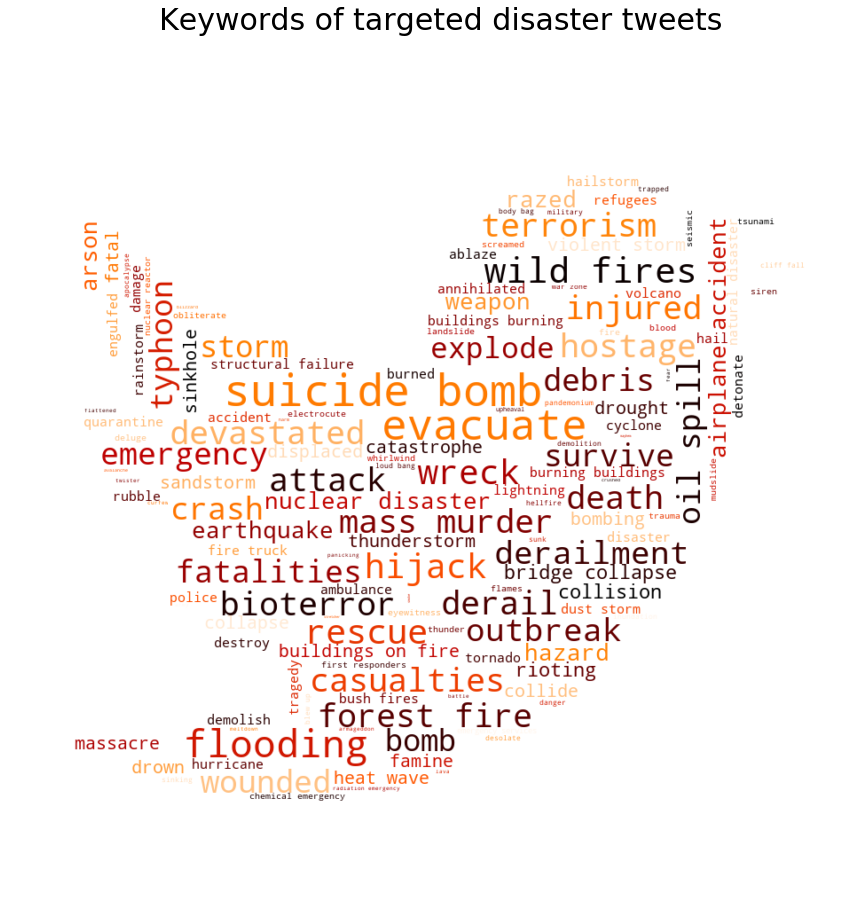

In [9]:
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

keywords_count = tweets.loc[tweets['target'] == 1].categorical_keyword.value_counts()
keywords_count.index = keywords_count.index.map(str)

mask = np.array(Image.open("./img/twitter_black.png"))
mask_transformed = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

for i in range(len(mask)):
    mask_transformed[i] = list(map(transform_format, mask[i]))

wordcloud = WordCloud(max_font_size=50, max_words=200, random_state=42, 
                      background_color='white', colormap='gist_heat',
                      mask=mask_transformed)
wordcloud.generate_from_frequencies(keywords_count)

plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Keywords of targeted disaster tweets", fontsize=30, pad=40)
plt.axis("off")
plt.show()

## Porcentaje de verdaderos y falsos por cada keyword

In [10]:
keywords_grouped = tweets.groupby(['categorical_keyword', 'target']).agg({'categorical_keyword':['count']})
keywords_level1 = keywords_grouped.columns.get_level_values(1)

print(keywords_level1)

keywords_grouped.columns = keywords_level1
keywords_grouped.reset_index(inplace=True)
keywords_grouped.head(10)

Index(['count'], dtype='object')


,categorical_keyword,target,count
0,ablaze,0,89
1,ablaze,1,19
2,accident,0,11
3,accident,1,24
4,aftershock,0,34
5,airplane accident,0,5
6,airplane accident,1,30
7,ambulance,0,18
8,ambulance,1,20
9,annihilated,0,42


In [11]:
keywords_total_count = tweets.groupby(['categorical_keyword']).agg({'categorical_keyword': ['count']})
keywords_total_count.columns = 'total_' + keywords_total_count.columns.get_level_values(1)
keywords_total_count.reset_index(inplace=True)
keywords_total_count.head(10)

,categorical_keyword,total_count
0,ablaze,108
1,accident,35
2,aftershock,34
3,airplane accident,35
4,ambulance,38
5,annihilated,63
6,apocalypse,32
7,armageddon,42
8,army,34
9,arson,66


In [12]:
keywords = keywords_grouped.merge(keywords_total_count, left_on='categorical_keyword', right_on='categorical_keyword', how='left')
keywords.loc[:,'percentage_count'] = (keywords.loc[:, 'count'] / keywords.loc[:, 'total_count']) * 100
keywords.head(10)

,categorical_keyword,target,count,total_count,percentage_count
0,ablaze,0,89,108,82.407407
1,ablaze,1,19,108,17.592593
2,accident,0,11,35,31.428571
3,accident,1,24,35,68.571429
4,aftershock,0,34,34,100.000000
5,airplane accident,0,5,35,14.285714
6,airplane accident,1,30,35,85.714286
7,ambulance,0,18,38,47.368421
8,ambulance,1,20,38,52.631579
9,annihilated,0,42,63,66.666667


## Keywords tweets más acertados, tomando como >= 90% targeted (Verdadero)

In [13]:
targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['target'] == 1)]
targeted_keywords

,categorical_keyword,target,count,total_count,percentage_count
40,bombing,1,27,29,93.103448
81,debris,1,37,37,100.000000
90,derailment,1,39,39,100.000000
194,nuclear disaster,1,31,34,91.176471
200,oil spill,1,37,38,97.368421
202,outbreak,1,39,40,97.500000
250,suicide bomb,1,94,99,94.949495
276,typhoon,1,37,38,97.368421


Text(0,0.5,'Keyword')

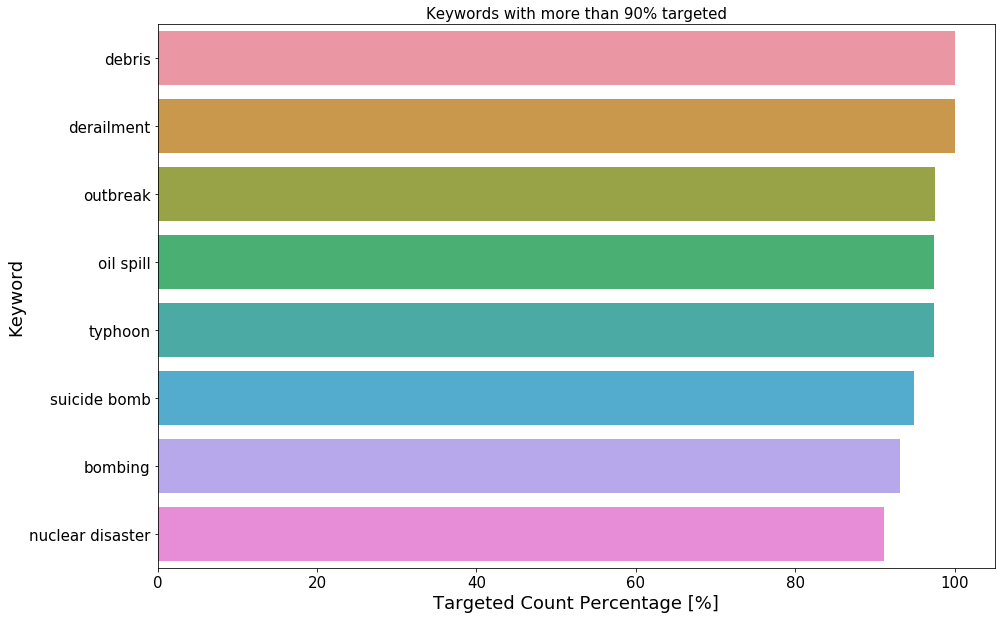

In [22]:
targeted_keywords = targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=targeted_keywords['percentage_count'], y=targeted_keywords['categorical_keyword'],
               orient='h')

g.set_title('Keywords with more than 90% targeted', fontsize=15)
g.set_xlabel('Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

## Keywords de tweets menos acertados, tomando como >= 90% not targeted (Falsos)

In [15]:
not_targeted_keywords = keywords.loc[(keywords['percentage_count'] >= 90) & (keywords['target'] == 0)]
not_targeted_keywords

# frequency >= 10

,categorical_keyword,target,count,total_count,percentage_count
4,aftershock,0,34,34,100.000000
29,blight,0,30,32,93.750000
35,body bag,0,100,107,93.457944
119,epicentre,0,11,12,91.666667
153,harm,0,37,41,90.243902
183,mayhem,0,27,30,90.000000
205,panicking,0,65,70,92.857143
225,ruin,0,36,37,97.297297
239,smoke,0,31,34,91.176471
245,stretcher,0,30,33,90.909091


Text(0,0.5,'Keyword')

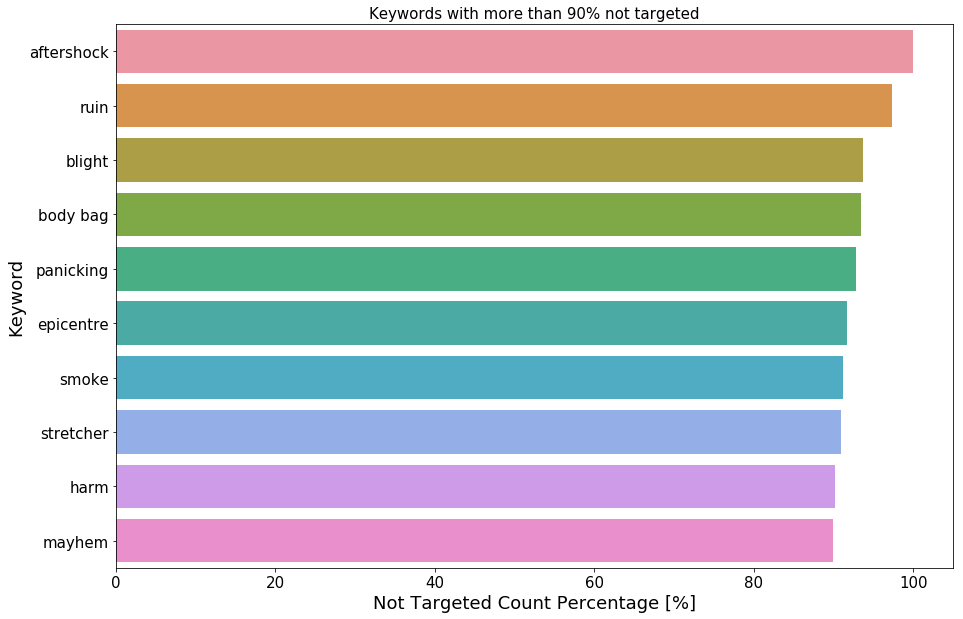

In [23]:
not_targeted_keywords = not_targeted_keywords.sort_values(['percentage_count'], ascending=False)
fig, ax = plt.subplots(figsize=(15,10))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
g = sns.barplot(x=not_targeted_keywords['percentage_count'], y=not_targeted_keywords['categorical_keyword'],
               orient='h')

g.set_title('Keywords with more than 90% not targeted', fontsize=15)
g.set_xlabel('Not Targeted Count Percentage [%]', fontsize=18)
g.set_ylabel('Keyword', fontsize=18)

## Distribución largo de la Keyword en función de si es verdadero o falso

In [17]:
keyword_tweets = tweets.dropna(subset=['keyword']).copy()
keyword_tweets['keyword_length'] = keyword_tweets['keyword'].apply(len)
keyword_tweets

,id,keyword,location,text,target,categorical_keyword,keyword_length
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,ablaze,6
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,ablaze,6
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,ablaze,6
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,ablaze,6
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,ablaze,6
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0,ablaze,6
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,ablaze,6
38,56,ablaze,NaN,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,ablaze,6
39,57,ablaze,Paranaque City,Ablaze for you Lord :D,0,ablaze,6
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,ablaze,6


In [18]:
keyword_length = keyword_tweets.groupby(['target'])\
                .agg({'keyword_length': ['count','mean','min','max']})
keyword_length.columns = keyword_length.columns.get_level_values(0) + \
                '_' + keyword_length.columns.get_level_values(1)
keyword_length.reset_index(inplace=True)
keyword_length

,target,keyword_length_count,keyword_length_mean,keyword_length_min,keyword_length_max
0,0,4323,7.993060,4,19
1,1,3229,8.991329,4,19


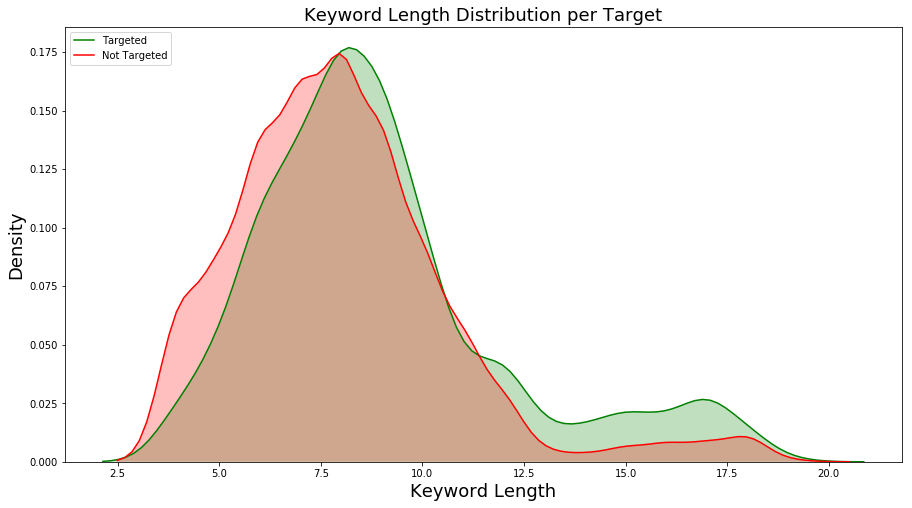

In [26]:
fig, ax = plt.subplots(figsize=(15,8))
g = sns.kdeplot(keyword_tweets.loc[(keyword_tweets['target'] == 1), :]['keyword_length'], 
                color='green',
                label='Targeted',
                shade=True,
               ax= ax)
g = sns.kdeplot(keyword_tweets.loc[(keyword_tweets['target'] == 0), :]['keyword_length'], 
                color='red',
                label='Not Targeted',
                shade=True,
               ax= ax)

g.set_title('Keyword Length Distribution per Target', fontsize=18)
g.set_xlabel('Keyword Length', fontsize=18)
g.set_ylabel('Density', fontsize=18)
g.legend(loc='upper left')

# Análisis de Location vs Target